Estimated lost revenue due to churn is ~\\$80/customer. Cost of outreach is ~$20/customer. A 3:1 ratio of false positives to true positives will be approximately net neutral, with lower ratios leading to more profits. The maximum value lies in maximizing the churn prevented while minimizing the cost of outreach to misidentified churners. The formula for profit/loss on this project would be: 80\*TP - 20\*(TP+FP).

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [178]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [179]:
df.nunique()

state                       51
account length             212
area code                    3
phone number              3333
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

Some observations:
* These are all unique phone numbers, no duplicates to deal with.
* There are 51 states represented, but only 3 area codes (I happen to know, because I live here, that these are all San Francisco Bay Area area codes.
* Churn, the result we would like to model, has 2 unique values, i.e.: it is a binary result.

In [180]:
print('Churn rate: ',round(df['churn'].value_counts()[1]/3333,3))

Churn rate:  0.145


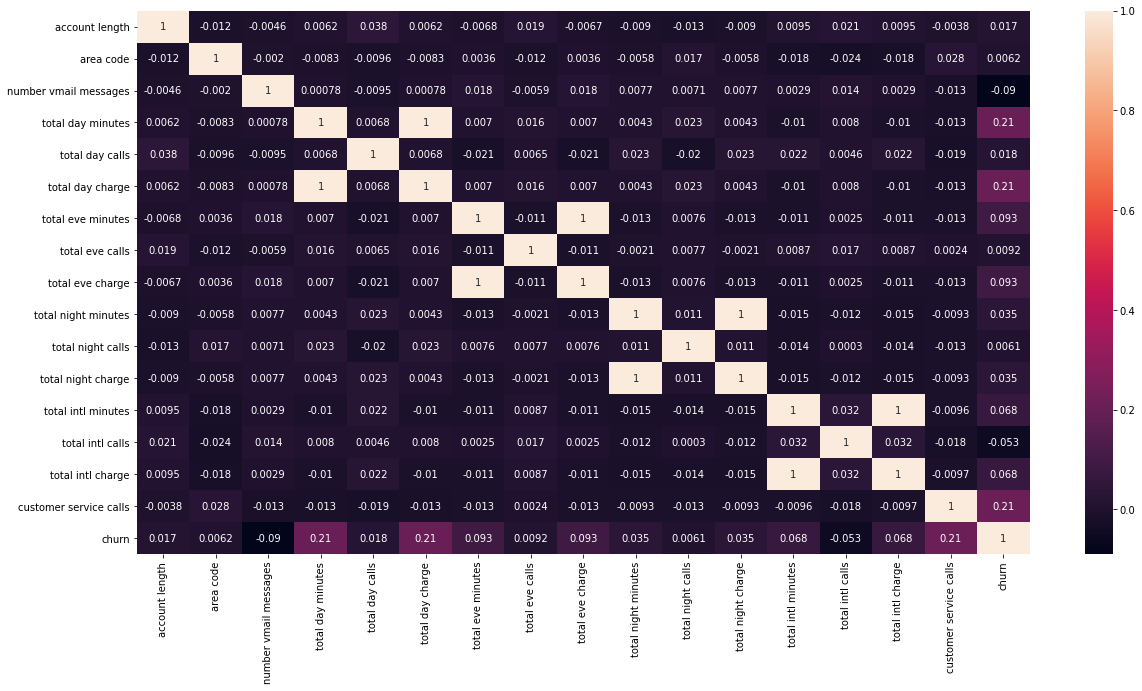

In [181]:
#Check correlation between features
corrmat = df.corr()

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True);

In [182]:
print(f"""Correlation between day minutes and charge: {df['total day minutes'].corr(df['total day charge'])}""")
print(f"""Correlation between eve minutes and charge: {df['total eve minutes'].corr(df['total eve charge'])}""")
print(f"""Correlation between night minutes and charge: {df['total night minutes'].corr(df['total night charge'])}""")
print(f"""Correlation between intl minutes and charge: {df['total intl minutes'].corr(df['total intl charge'])}""")

Correlation between day minutes and charge: 0.9999999521903998
Correlation between eve minutes and charge: 0.9999997760198508
Correlation between night minutes and charge: 0.9999992148758774
Correlation between intl minutes and charge: 0.9999927417510311


In [183]:
df_filtered = df.drop(['total day charge','total eve charge','total night charge','total intl charge'],axis=1)

In [184]:
# One hot encoding for categorical columns
categorical = ['state','area code', 'international plan', 'voice mail plan','churn']
df_encoded = pd.get_dummies(df_filtered, columns=categorical, drop_first=True)

In [185]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

In [186]:
# Set seed for random states to be consistent throughout
SEED=37

# Define the X and y for the model
X = df_encoded.drop(['churn_True','phone number'], axis=1)
y = df_encoded.churn_True

# Train test split from full data.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X,y, random_state=SEED, train_size=0.8)

# Further split the training data set for model selection and hypertuning parameters. The X_train/y_train set will 
# train these intermediate models, which will be evaulated using X_test/y_test. 
X_train, X_test, y_train, y_test = train_test_split(X_train_final,y_train_final, random_state=SEED, train_size=0.7)

# Once all of the parameters are established,the X_train_final/y_train_final and X_test_final/y_test_final sets will
# be used to train and test the final model.

In [187]:
# This will be the function I use to calculate the dollar value of the current model.
revenue_recaptured = 80
outreach_cost = 20


def model_eval(model_name,X_test,y_test):
    y_hat_test = model_name.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat_test)
#     ConfusionMatrixDisplay(conf_mat).plot();
    rec_score = recall_score(y_test,y_hat_test)
    profit_loss = round(revenue_recaptured*conf_mat[1,1]-outreach_cost*(conf_mat[0,1]+conf_mat[1,1]),2)
    print(f'Profit(loss): ${profit_loss}')
#     print(f'Recall: {round(rec_score,3)}')
    
    return(profit_loss)

In [188]:
# Creating a version that doesn't print the result to used to generate data points for graphs

def model_eval_no_print(model_name,X_test,y_test):
    y_hat_test = model_name.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat_test)
#     ConfusionMatrixDisplay(conf_mat).plot();
    rec_score = recall_score(y_test,y_hat_test)
    profit_loss = round(revenue_recaptured*conf_mat[1,1]-outreach_cost*(conf_mat[0,1]+conf_mat[1,1]),2)
   
    return(profit_loss)

In [189]:
logreg_base = LogisticRegression(random_state=SEED, fit_intercept=False, C=1e10, solver='liblinear')
logreg_base.fit(X_train.values,y_train) # added .values to handle labeling error

model_eval(logreg_base,X_test.values,y_test);

Profit(loss): $720


In [190]:
# Scaling everything to a 0-1 range

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
logreg_scaled = LogisticRegression(random_state=SEED,fit_intercept=False, C=1e10, solver='liblinear')
logreg_scaled.fit(X_train_scaled,y_train)
model_eval(logreg_scaled,X_test_scaled,y_test);

Profit(loss): $460


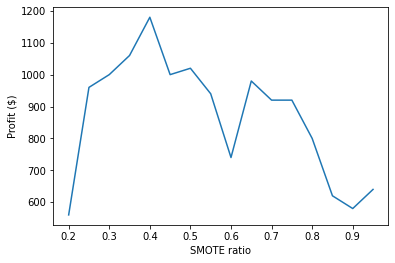

In [192]:
ratios = np.arange(.2,1,.05)
dollars_smote = []

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train) 
    X_test_resampled, y_test_resampled = smote.fit_resample(X_test_scaled, y_test)
    logreg = LogisticRegression(fit_intercept=False, C=1e10, solver ='liblinear')
    logreg.fit(X_train_resampled, y_train_resampled)
    result = model_eval_no_print(logreg,X_test_scaled,y_test)
    dollars_smote.append(result)
    
fig, ax = plt.subplots()
ax.plot(ratios,dollars_smote,label='Profit ($)')
ax.set_ylabel('Profit ($)')
ax.set_xlabel('SMOTE ratio')
plt.show();

In [193]:
smote = SMOTE(sampling_strategy=0.4, random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train) 
logreg_resample = LogisticRegression(fit_intercept=False, C=1e10, solver ='liblinear')
logreg_resample.fit(X_train_resampled, y_train_resampled)

model_eval(logreg_resample,X_test_scaled,y_test);

Profit(loss): $1180


In [194]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, roc_auc_score

Profit for entropy:
Profit(loss): $4000

Profit for gini:
Profit(loss): $4080

Profit for log loss:
Profit(loss): $4000


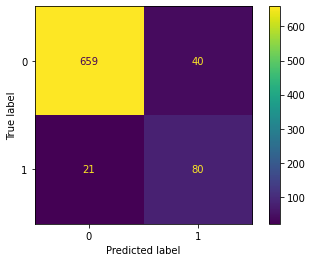

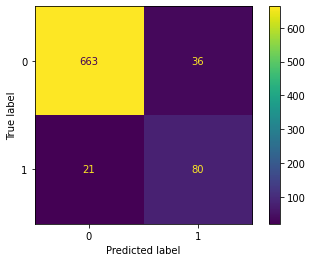

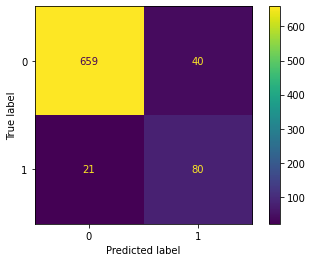

In [195]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
clf.fit(X_train, y_train)
print('Profit for entropy:')
model_eval(clf,X_test,y_test);
y_hat_test = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

clf_g = DecisionTreeClassifier(criterion='gini',random_state=SEED)
clf_g.fit(X_train, y_train)
print('\nProfit for gini:')
model_eval(clf_g,X_test,y_test);
y_hat_test = clf_g.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

clf_ll = DecisionTreeClassifier(criterion='log_loss',random_state=SEED)
clf_ll.fit(X_train, y_train)
y_hat_test = clf_ll.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();
print('\nProfit for log loss:')
model_eval(clf_ll,X_test,y_test);

The model that uses gini as the criterion is slightly better (by 2%, but still).

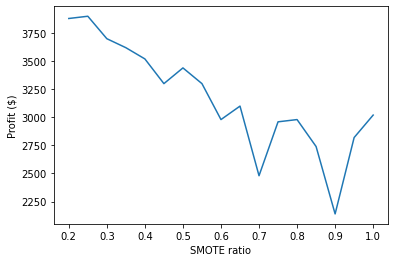

In [196]:
ratios = np.arange(.2,1.05,.05)
dollars_smote_tree = []
for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=round(ratio,3), random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train) 
    X_test_resampled, y_test_resampled = smote.fit_resample(X_test_scaled, y_test)
    clf_resamp_temp = DecisionTreeClassifier(criterion='gini',random_state=SEED)
    clf_resamp_temp.fit(X_train_resampled, y_train_resampled)
    result = model_eval_no_print(clf_resamp_temp,X_test_scaled,y_test)
    dollars_smote_tree.append(result)
    
fig, ax = plt.subplots()
ax.plot(ratios,dollars_smote_tree,label='Profit ($)')
ax.set_ylabel('Profit ($)')
ax.set_xlabel('SMOTE ratio')
plt.show();

    # Not better than baseline in terms of profit.

In [197]:
def hypertuning(parameter,X_train,y_train,X_test,y_test,start,stop,increment):
    parameter_range = np.arange(start,stop,increment)
    temp_range=[]
    test_aucs=[]
    train_aucs=[]
    profit=[]
    for i in parameter_range:
        param_name = parameter
        param_value = i
        
        # With assistance from ChatGPT - it gave me this method to set parameter names using variables so I can 
        # call this function with any parameter I want and have it run through a range of parameters.
        kwargs = {param_name: param_value, 'random_state':SEED,'criterion':'gini'}
        dt_temp = DecisionTreeClassifier(**kwargs)
        # Thanks ChatGPT!!
        
        dt_temp.fit(X_train,y_train)
        y_pred_train = dt_temp.predict(X_train)
        y_pred_test = dt_temp.predict(X_test)
        auc_train_temp = round(roc_auc_score(y_train, y_pred_train),3)
        auc_test_temp = round(roc_auc_score(y_test, y_pred_test),3)
        temp_range.append(i)
        test_aucs.append(auc_test_temp)
        train_aucs.append(auc_train_temp)
        profit.append(model_eval_no_print(dt_temp,X_test,y_test))
        
    fig, ax1 = plt.subplots()
    ax1.plot(temp_range,test_aucs,label='Test')
    ax1.plot(temp_range,train_aucs,label='Train')
    ax2 = ax1.twinx()
    ax2.plot(temp_range,profit,label='Profit',color='g')
    ax1.set_ylabel('AUC')
    ax2.set_ylabel('Profit ($)')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    plt.show();

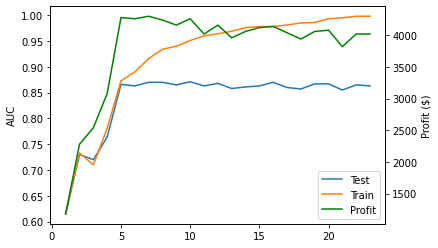

In [198]:
hypertuning("max_depth",X_train,y_train,X_test,y_test,1,24,1)

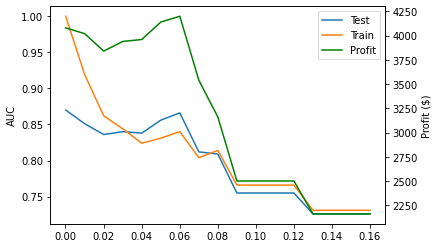

In [199]:
hypertuning("min_samples_split",X_train,y_train,X_test,y_test,0.0001,.17,.01)

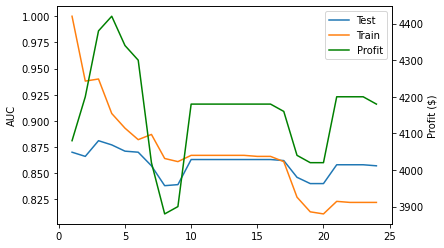

In [200]:
hypertuning("min_samples_leaf",X_train,y_train,X_test,y_test,1,25,1)

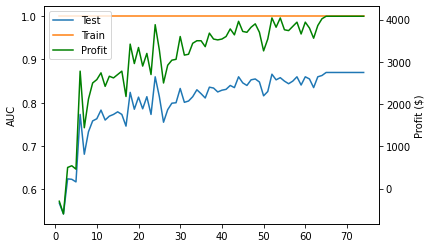

In [201]:
hypertuning("max_features",X_train,y_train,X_test,y_test,1,75,1)

In [206]:
dt_final = DecisionTreeClassifier(random_state=SEED,criterion='gini',min_samples_leaf=4,max_depth=5,max_features=65)
dt_final.fit(X_train_final,y_train_final)
model_eval(dt_final,X_test_final,y_test_final)

Profit(loss): $3840


3840

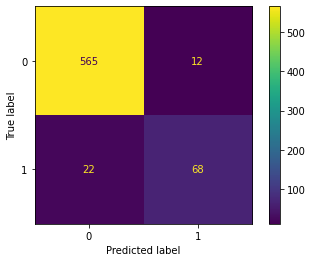

In [207]:
y_hat_test = dt_final.predict(X_test_final)
conf_mat = confusion_matrix(y_test_final, y_hat_test)
ConfusionMatrixDisplay(conf_mat).plot();

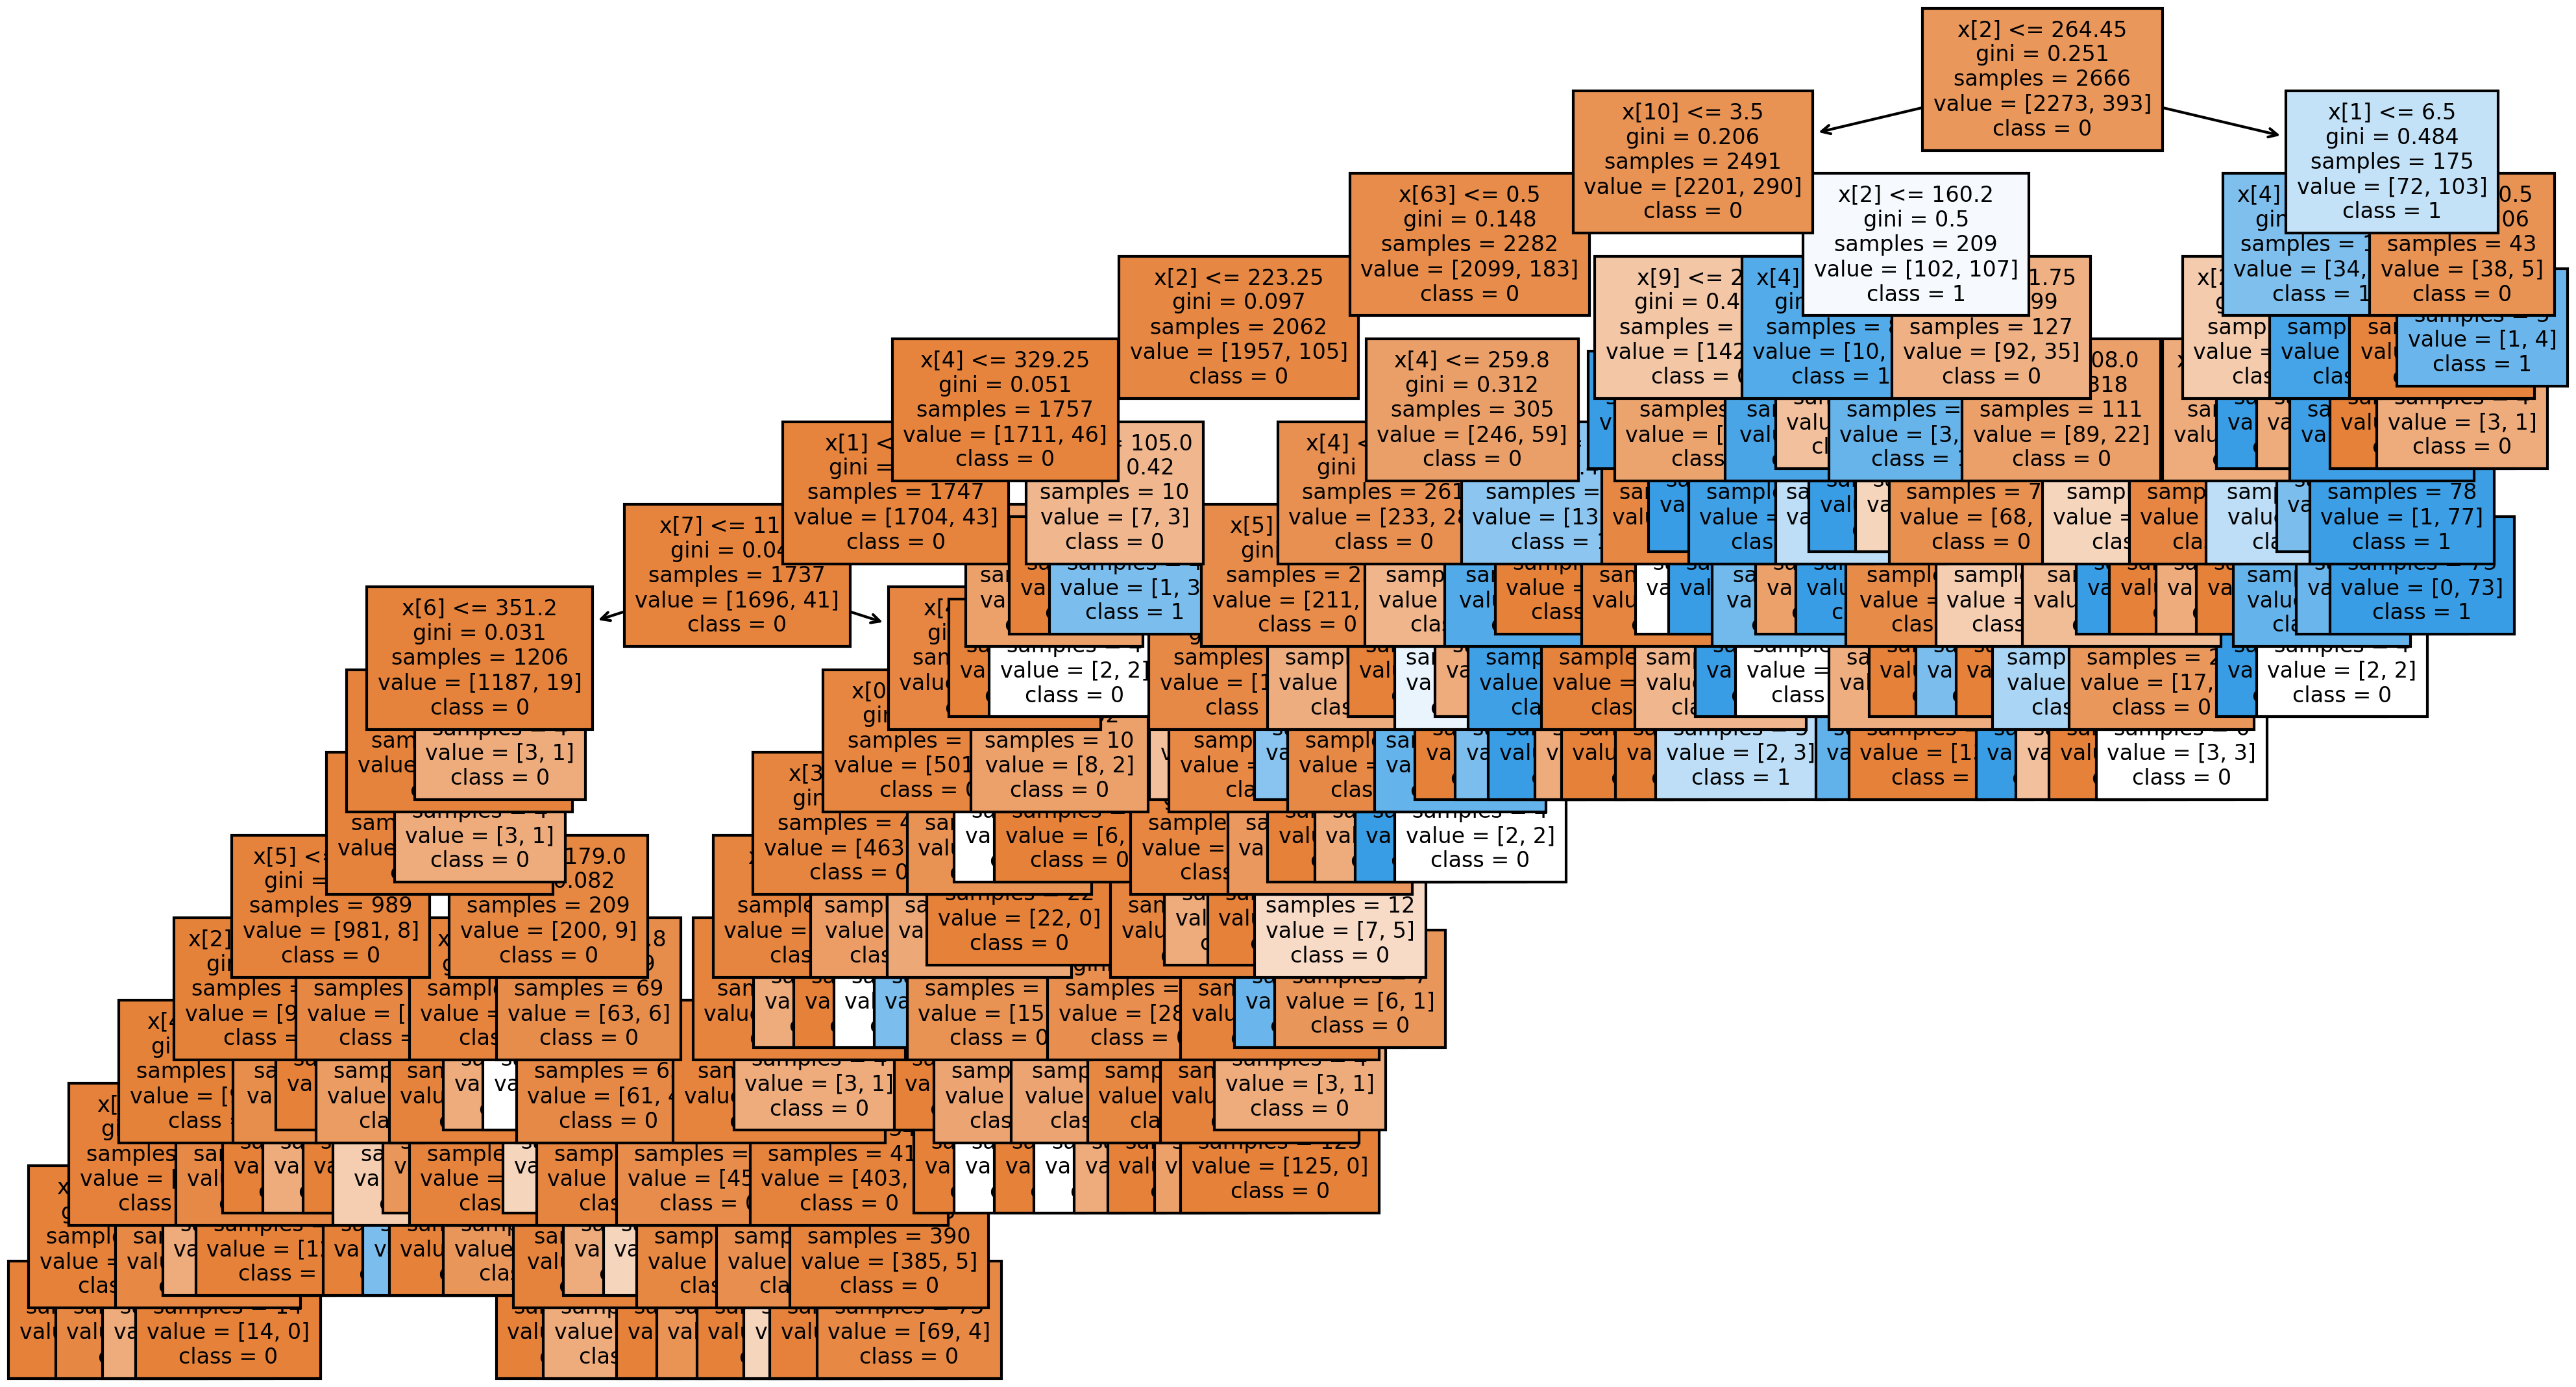

In [204]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (16,9), dpi=300)
tree.plot_tree(dt_final,
               class_names=np.unique(y).astype('str'),
               fontsize=8,
               filled = True)
plt.show()